In [1]:
import csv
import cv2
import os
import numpy as np
import keras

os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf

import random

Using TensorFlow backend.


In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [3]:
#input_path = '/home/brian/Documents/Training/Udacity/Self_Driving_Car/beta_simulator_linux/beta_simulator_Data/'
# input_path = '/home/brian/Documents/Training/Udacity/Self_Driving_Car/data/data/data/'
#input_path = '/home/workspace/CarND-Behavioral-Cloning-P3/data'
input_path = '/home/ec2-user/SageMaker/data'
image_path = input_path + 'IMG/'

lines = []
with open(os.path.join(input_path, 'driving_log.csv')) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

lines = np.delete(lines, (0), axis=0)
line_array = np.array(lines)

#calculate moving average
data = line_array[:,3]
data = data.astype(float)

numparts = 5
w = np.arange(1., numparts+1.)
w = w/np.sum(w)

test = np.array([0.0,0.0])
ma = np.convolve(data,w[::-1],'valid')

ma_1 = np.concatenate((test, ma), axis = 0)
ma_2 = np.concatenate((ma_1, test), axis = 0)
ma_2 = ma_2.reshape(len(ma_2), 1)

all_data = np.hstack((line_array, ma_2))

print(min(data))
print(max(data))

print(min(ma_2))
print(max(ma_2))

-0.9426954
1.0
[-0.75226486]
[0.52423897]


(array([1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 4.000e+00, 1.000e+00,
        1.100e+01, 1.200e+01, 2.100e+01, 3.800e+01, 6.400e+01, 9.200e+01,
        1.190e+02, 1.690e+02, 3.100e+02, 3.900e+02, 6.370e+02, 3.665e+03,
        7.570e+02, 5.370e+02, 4.350e+02, 3.880e+02, 1.440e+02, 9.300e+01,
        5.700e+01, 4.300e+01, 2.500e+01, 1.400e+01, 5.000e+00, 2.000e+00]),
 array([-0.75226486, -0.70971473, -0.6671646 , -0.62461448, -0.58206435,
        -0.53951422, -0.49696409, -0.45441397, -0.41186384, -0.36931371,
        -0.32676358, -0.28421346, -0.24166333, -0.1991132 , -0.15656307,
        -0.11401295, -0.07146282, -0.02891269,  0.01363744,  0.05618756,
         0.09873769,  0.14128782,  0.18383795,  0.22638807,  0.2689382 ,
         0.31148833,  0.35403846,  0.39658858,  0.43913871,  0.48168884,
         0.52423897]),
 <a list of 30 Patch objects>)

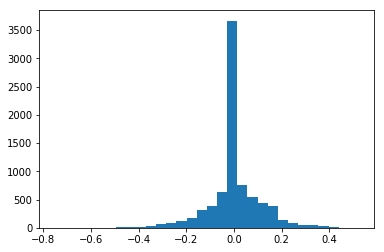

In [4]:
plt.hist(ma_2, bins=30)

In [12]:
images = []
measurements = []
for line in all_data:
    for i in range(3):
        source_path = line[0]
        correction = 0.2
        filename = source_path.split('/')[-1]
        current_path = os.path.join(os.path.join(input_path, 'IMG/', filename))
        original_image = cv2.imread(current_path)
        image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        actual_turn = np.round(float(line[3]), decimals=2)
        
        if 'left' in current_path:
            measurement = np.round(float(line[7]), decimals=2) + correction
            actual_turn = np.round(float(line[3]), decimals=2) + correction
        elif 'right' in current_path:
            measurement = np.round(float(line[7]), decimals=2) - correction
            actual_turn = np.round(float(line[3]), decimals=2) - correction
        else :
            measurement = np.round(float(line[7]), decimals=2)
            actual_turn = np.round(float(line[3]), decimals=2)
        
        images.append(image)
        measurements.append(actual_turn)
        images.append(cv2.flip(image,1))
        measurements.append(measurement*-1.0)
'''
        if abs(measurement) <= 0.21:
            if random.randint(1,11) <= 8 :                
                images.append(image)
                measurements.append(measurement)
        else:
            if actual_turn > 0.3 or actual_turn < -0.3:
                images.append(image)
                measurements.append(actual_turn)
                images.append(image)
                measurements.append(actual_turn + 0.01)
                images.append(image)
                measurements.append(actual_turn - 0.01)
                if actual_turn > 0.5 or actual_turn < -0.5:
                    for i in range(-10,10,1):
                        inc = i*0.002
                        images.append(image)
                        measurements.append(actual_turn+inc)
            
            images.append(image)
            measurements.append(measurement)
            images.append(image)
            measurements.append(measurement + 0.01)
            images.append(image)
            measurements.append(measurement - 0.01)
'''
        
        


'\n        if abs(measurement) <= 0.21:\n            if random.randint(1,11) <= 8 :                \n                images.append(image)\n                measurements.append(measurement)\n        else:\n            if actual_turn > 0.3 or actual_turn < -0.3:\n                images.append(image)\n                measurements.append(actual_turn)\n                images.append(image)\n                measurements.append(actual_turn + 0.01)\n                images.append(image)\n                measurements.append(actual_turn - 0.01)\n                if actual_turn > 0.5 or actual_turn < -0.5:\n                    for i in range(-10,10,1):\n                        inc = i*0.002\n                        images.append(image)\n                        measurements.append(actual_turn+inc)\n            \n            images.append(image)\n            measurements.append(measurement)\n            images.append(image)\n            measurements.append(measurement + 0.01)\n            images.append

In [13]:
X_train = np.array(images)
y_train = np.array(measurements)

In [6]:
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    random_bright = .25+np.random.uniform() 

    # add brightness
    bright_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    bright_image[:,:,2] = bright_image[:,:,2]*random_bright       

    if round(measurement,2) <= 0.05:
        if random.randint(1,501) <= 50 :
            augmented_images.append(image)
            augmented_measurements.append(measurement)
            augmented_images.append(cv2.flip(image,1))
            augmented_measurements.append(measurement*-1.0)
            augmented_images.append(cv2.flip(bright_image,1))
            augmented_measurements.append(measurement*-1.0)
    else:
        augmented_images.append(bright_image)
        augmented_measurements.append(measurement)
        augmented_images.append(cv2.flip(image,1))
        augmented_measurements.append(measurement*-1.0)
        augmented_images.append(cv2.flip(bright_image,1))
        augmented_measurements.append(measurement*-1.0)

    
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

(array([1.2000e+01, 0.0000e+00, 0.0000e+00, 3.0000e+00, 3.0000e+00,
        3.0000e+00, 6.0000e+00, 6.0000e+00, 6.0000e+00, 0.0000e+00,
        1.2000e+01, 4.8000e+01, 1.2000e+02, 1.0200e+02, 1.5600e+02,
        2.4300e+02, 3.9000e+02, 4.3200e+02, 6.8400e+02, 1.0380e+03,
        2.0760e+03, 1.8750e+03, 3.0660e+03, 2.8710e+03, 2.4519e+04,
        2.1510e+03, 2.3490e+03, 1.3830e+03, 2.0460e+03, 6.9000e+02,
        4.3800e+02, 5.8500e+02, 1.9500e+02, 3.3600e+02, 1.1700e+02,
        8.4000e+01, 8.7000e+01, 2.1000e+01, 9.0000e+00, 2.4000e+01,
        1.2000e+01, 6.0000e+00, 0.0000e+00, 6.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([-0.94  , -0.9012, -0.8624, -0.8236, -0.7848, -0.746 , -0.7072,
        -0.6684, -0.6296, -0.5908, -0.552 , -0.5132, -0.4744, -0.4356,
        -0.3968, -0.358 , -0.3192, -0.2804, -0.2416, -0.2028, -0.164 ,
        -0.1252, -0.0864, -0.0476, -0.0088,  0.03  ,  0.0688,  0.1076,
         0.1464,  0.1852,  0.224 ,

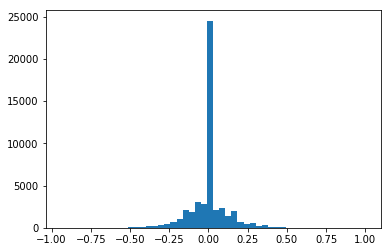

In [14]:
plt.hist(y_train, bins=50)

In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D
from keras.layers import BatchNormalization
from keras.layers import ELU
from keras.layers import Dropout

#with tf.device("/cpu:0"):
#    model = Sequential()

model = Sequential()
#model = multi_gpu_model(model, gpus=2, cpu_relocation=True)
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160, 320, 3))) #, output_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))

model.add(Conv2D(24,(5,5), activation='relu'))
model.add(ELU())
#model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(36,(5,5), activation='relu'))
model.add(ELU())
#model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(48,(5,5), activation='relu'))
model.add(ELU())
#model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(ELU())
#model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(ELU())
model.add(Dropout(0.5))

model.add(Flatten())
#model.add(ELU())

#model.add(Dense(512))
#model.add(Dropout(0.4))
#model.add(ELU())

model.add(Dense(100))
#model.add(Dropout(0.4))
model.add(ELU())

model.add(Dense(50))
#model.add(Dropout(0.4))
model.add(ELU())

model.add(Dense(10))
#model.add(Dropout(0.4))
model.add(ELU())

model.add(Dense(1))

Train on 45805 samples, validate on 2411 samples
Epoch 1/5
45805/45805 [==============================] - 705s 15ms/step - loss: 0.6274 - val_loss: 0.0122
Epoch 2/5
45805/45805 [==============================] - 698s 15ms/step - loss: 0.0089 - val_loss: 0.0155
Epoch 3/5
45805/45805 [==============================] - 698s 15ms/step - loss: 0.0079 - val_loss: 0.0107
Epoch 4/5
45805/45805 [==============================] - 697s 15ms/step - loss: 0.0076 - val_loss: 0.0142
Epoch 5/5
45805/45805 [==============================] - 696s 15ms/step - loss: 0.0073 - val_loss: 0.0164
dict_keys(['val_loss', 'loss'])


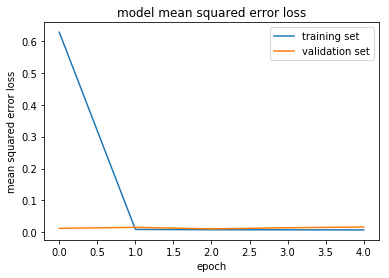

In [16]:
model.compile(loss='mse', optimizer='adam')#, options = run_opts)

history_object = model.fit(x=X_train, y=y_train
                           , batch_size = 64
                           , verbose=1
                           , validation_split=0.05
                           , epochs=5)

#model.fit(X_train, y_train, validation_split=0.4, shuffle=True, epochs=10)

model.save('model_36.h5')

import matplotlib.pyplot as plt

#history_object = model.fit_generator(train_generator, samples_per_epoch =
#    len(train_samples), validation_data = 
#    validation_generator,
#    nb_val_samples = len(validation_samples), 
#    nb_epoch=5, verbose=1)

## print the keys contained in the history object
print(history_object.history.keys())

## plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()